# Derivation

Discretely many importance weights and rewards; a logging policy $h$; two policies whose value difference is being estimated; maximum likelihood of sample $\{ (u_i, w_i, r_i) \}$ drawn from $h$ is $$
\begin{alignat}{2}
&\!\max_{Q \succeq 0} &\qquad& \sum_n \log(Q_{u_n, w_n, r_n}),\label{eq:mle}\\
&\text{subject to} &  & \sum_{u, w, r} Q_{u, w, r} = 1, \tag{$\beta$} \label{eq:mlesum} \\
&                  &  & \sum_{u, w, r} u Q_{u, w, r} = 1, \tag{$\gamma$} \label{eq:mlesumu} \\
&                  &  & \sum_{u, w, r} w Q_{u, w, r} = 1, \tag{$\tau$} \label{eq:mlesumw} \\
\end{alignat}
$$
Estimate is $\hat \Delta V = \sum_{u, w, r} (u - w) Q_{u, w, r} r$.

Dual (ignoring constants) is $$
\begin{aligned}
\sup_{\beta,\gamma,\tau}& -\beta - \gamma -\tau + \sum_{n} \log\left(\beta + u_n \gamma + w_n \tau\right)\; \text{ s.t. } \; \forall u,w,r: \beta + u \gamma + w \tau \geq 0.
\end{aligned}
$$ One dual variable can be eliminated by summing the KKT stationarity conditions and leveraging complementary slackness.  Introducing $\phi \succeq 0$ as the (matrix of) dual variables associated with $Q \succeq 0$: $$
\begin{aligned}
\frac{c_{w_i,r_j}}{q_{w_i,r_j}} &= \phi_{w_i,r_j} + \beta + u_i \gamma + w_i \tau \implies N = 0 + \beta + \gamma + \tau, \\
\end{aligned}
$$ resulting in the 2-D dual $$
\begin{aligned}
\sup_{\gamma,\tau} & \sum_{n} \log\left((u_n - 1) \gamma + (w_n - 1) \tau + N\right) \; \text{ s.t. } \;\forall u,w,r: (u - 1) \gamma + (w - 1) \tau + N \geq 0.
\end{aligned}
$$ Unobserved mass can only be assigned at zeros of the dual constraint, but is associated an arbitrary reward.  Primal feasibility dictates $$
\begin{aligned}
1 &= \sum_{(u, w) \in \text{zeros}} u q_{(u, w)} + \sum_n u_n Q_{u_n, w_n, r_n} \\
1 &= \sum_{(u, w) \in \text{zeros}} w q_{(u, w)} + \sum_n w_n Q_{u_n, w_n, r_n} \\
0 &= \sum_{(u, w) \in \text{zeros}} (u - w) q_{(u, w)} + \sum_n (u_n - w_n) Q_{u_n, w_n, r_n} \\
\end{aligned}
$$ Therefore the possible difference due to unobserved mass is given by $$
\begin{aligned}
\rho \sum_{(u, w) \in \text{zeros}} (u - w) q_{(u, w)} &= -\rho \sum_n (u - w) Q_{u_n, w_n, r_n} \\
\end{aligned}
$$ where $\rho$ ranges over $[r_{\min}, r_{\max}]$.  The value estimate becomes $$
\begin{aligned}
\hat \Delta V &= \sum_n \frac{(u_n - w_n) (r_n - \rho)}{(u_n - 1) \gamma^* + (w_n - 1) \tau^* + N} 
\end{aligned}
$$

# Tests

# Comparison with baselines

In [2]:
def produceresults(env, method, maxexp=5, numpts=20, ndataperpt=10000):
    from math import ceil
    import numpy as np
    
    (umin, umax), (wmin, wmax) = env.range()

    for ndata in map(ceil, np.logspace(1, maxexp, numpts)):
        estimates=[]
        for i in range(1, ndataperpt+1):
            (utrue, wtrue, data) = env.sample(ndata)
            deltatrue = utrue - wtrue
            try:
                estimate = None
                estimate = method(data=data, umin=umin, umax=umax, wmin=wmin, wmax=wmax)
                assert np.isfinite(estimate)
            except:
                print('truevalue was {}'.format((utrue, wtrue, deltatrue)))
                print('data was {}'.format(data))
                print('estimate was {}'.format(estimate))
                raise
                                                
            estimates.append(
                ( deltatrue,
                  deltatrue - estimate,
                  (deltatrue - estimate)**2,
                )  
            )
            
        yield (ndata,
                { 
                    'bias': np.abs(np.mean([ x[1] for x in estimates])),
                    'biasstd': np.std([ x[1] for x in estimates ], ddof=1) / np.sqrt(len(estimates) - 1),
                    'mse': np.mean([ x[2] for x in estimates ]),
                    'msestd': np.std( [ x[2] for x in estimates ], ddof=1) / np.sqrt(len(estimates) - 1),
                },
              )
        
class ClippedDR:
    @staticmethod
    def estimate(data, baseline=0.0, **kwargs):
        import numpy as np
        n = sum(c for c, _, _, _ in data)
        return baseline if n == 0 else np.clip(sum(c*(u-w)*(r-baseline) for c, u, w, r in data) / n, 
                                               a_min=-1, 
                                               a_max=1)
    
class SNIPS:
    @staticmethod
    def estimate(data, baseline=0.5, **kwargs):
        effnu = sum(c*u for c, u, w, _ in data)
        estu = baseline if effnu == 0 else sum(c*u*r for c, u, w, r in data) / effnu
        effnw = sum(c*w for c, u, w, _ in data)
        estw = baseline if effnw == 0 else sum(c*w*r for c, u, w, r in data) / effnw

        return estu - estw

from environments.DoubleControlledRangeVariance import DoubleControlledRangeVariance as DCRV
import MLE.MLE

def getenv(wmax):
    usupport = [ 0, 4, 500 ]
    wsupport = [ 0, 2, wmax ]
    env = DCRV(seed=45, usupport=usupport, expusq=50, wsupport=wsupport, expwsq=100)
    return env

allres = []
for (name, method) in [ ('Constant 0.0', lambda **kwargs: 0.0),
                        ('ClippedDR', ClippedDR.estimate),
                        ('SNIPS', SNIPS.estimate),
                        ('MLE', lambda data, **kwargs: MLE.MLE.estimatediff(datagen=lambda: data, **kwargs)[0]),
                      ]:
    print('****** {} ******'.format(name))
    res = []
    wmax = 1000
    for zzz in produceresults(getenv(wmax), method, ndataperpt=10000, numpts=14):
        res.append(zzz)
#         print('{}'.format(zzz), flush=True)
    allres.append((name, [(x[0] / wmax, x[1]) for x in res]))
    del wmax
import pickle
pickle.dump( allres, open( "epsilongreedy_estimatediff_allres.p", "wb" ) )

****** Constant 0.0 ******
****** ClippedDR ******
****** SNIPS ******
****** MLE ******


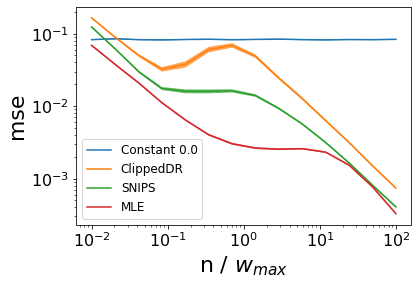

In [3]:
%matplotlib inline

class FlassPlot:
    @staticmethod
    def pic(x, y, label):
        import matplotlib.pyplot as plt
        
        plt.loglog(x, y, label=label)
        plt.legend()
        
    @staticmethod
    def forpaper():
        import matplotlib.pyplot as plt

        LEGEND_SIZE = 12
        SMALL_SIZE = 16
        MEDIUM_SIZE = 22
        BIGGER_SIZE = 24

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    @staticmethod
    def axeslabel(xlabel, ylabel):
        import matplotlib.pyplot as plt
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    @staticmethod
    def title(title):
        import matplotlib.pyplot as plt
        
        plt.title(title)
        
    @staticmethod
    def savefig(filename):
        import matplotlib.pyplot as plt
        
        plt.savefig(filename, bbox_inches='tight')
        
    @staticmethod
    def plt():
        import matplotlib.pyplot as plt
        
        return plt
  
import pickle
allres = pickle.load(open( "epsilongreedy_estimatediff_allres.p", "rb" ) )

renameit = { }
FlassPlot.forpaper()
for name, res in allres:
    x = [ x[0] for x in res ]
    y = [ x[1]['mse'] for x in res ]
    ylo = [ x[1]['mse'] - 1.96 * x[1]['msestd'] for x in res ]
    yhi = [ x[1]['mse'] + 1.96 * x[1]['msestd'] for x in res ]
    FlassPlot.plt().loglog([ x[0] for x in res ], [ x[1]['mse'] for x in res ], label=renameit.get(name, name))
    FlassPlot.plt().fill_between(x, ylo, yhi, alpha=0.7)
FlassPlot.plt().legend()

FlassPlot.axeslabel('n / $w_{max}$', 'mse')
FlassPlot.plt().savefig("epsilongreedydiff_mse.pdf", bbox_inches='tight')